In [ ]:
import keras
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os


batch_size = 128
n_epochs = 12
per_sample_normalization = True
data_augmentation = False
globalAVGPooling = False
drop_out = False
gt_noise = 0.
data_unbalancing = True
capacity = ['low', 'high'][0]
last_layer_activation = ['softmax', 'sigmoid', None][0]
loss = ['categorical_crossentropy', 'mean_squared_error', 'mean_absolute_error'][0]
txt = 'rnd'
vis_data = False

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [ ]:
# Load data
# To avoid filling up the RAM with repeated data, we load the data once
if not os.path.isfile('cifar10.npy'):
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train = x_train.astype('float32')
  n, h, w, c = x_test.shape
  x_test = x_test.astype('float32')# + (np.random.rand(n, h, w, c)-0.5)*0.02
 
  num_classes = 10
  y_train = y_train_reserve = np_utils.to_categorical(y_train, num_classes)
  y_test = np_utils.to_categorical(y_test, num_classes)

  with open('cifar10.npy', 'wb') as f:
    np.save(f, x_train)
    np.save(f, y_train)
    np.save(f, x_test)
    np.save(f, y_test)

  print(x_train.shape)
  if vis_data:
    rows, columns = 5, 5
    # define figure
    fig=plt.figure(figsize=(10, 10))
    # visualize these random images
    for i in range(1, rows*columns +1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(x_train[np.random.randint(0, x_train.shape[0])].astype('uint8'))
      plt.xticks([])
      plt.yticks([])
    plt.show()

# We corrupt some labels to analyze the capacity of the network
if gt_noise > 0:
  ridx = np.random.randint(0, y_train.shape[0], int(y_train.shape[0]*gt_noise))
  rlabel = np.random.randint(0, num_classes, ridx.shape[0])
  y_train = y_train_reserve # we reset the y_train to avoid accumulating the noise from previous iterations
  y_train[ridx] = np_utils.to_categorical(rlabel, num_classes)
else:
  y_train = y_train_reserve

In [ ]:
# Build the network
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
if capacity is 'high':
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
if drop_out:
  model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
if capacity is 'high':
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
if drop_out:
  model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
if capacity is 'high':
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
if drop_out:
  model.add(Dropout(0.4))

if globalAVGPooling:
  model.add(GlobalAveragePooling2D())
else:
  model.add(Flatten())

model.add(Dense(num_classes, activation=last_layer_activation))
 
model.summary()

In [ ]:
#training

#data augmentation
val_data_gen_args = dict(rescale = None if per_sample_normalization else 1./255,
                     samplewise_center=True if per_sample_normalization else False,
                     samplewise_std_normalization=True if per_sample_normalization else False)
train_data_gen_args = dict(rescale = None if per_sample_normalization else 1./255,
                     samplewise_center=True if per_sample_normalization else False,
                     samplewise_std_normalization=True if per_sample_normalization else False,
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2) if data_augmentation else val_data_gen_args
training_datagen = ImageDataGenerator(train_data_gen_args)
training_set = training_datagen.flow(x_train, y_train, batch_size=batch_size)
val_datagen = ImageDataGenerator(val_data_gen_args)
val_set = val_datagen.flow(x_test, y_test, batch_size=batch_size)
 
opt_rms = optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
model.compile(loss=loss, optimizer=opt_rms, metrics=['accuracy'])
mdl_fit = model.fit_generator(training_set,
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=n_epochs, verbose=1,
                    validation_data=val_set, callbacks=[LearningRateScheduler(lr_schedule)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/12
390/390 [==============================] - 19s 42ms/step - loss: 2.3156 - accuracy: 0.3203 - val_loss: 2.2104 - val_accuracy: 0.2547 - lr: 0.0010
Epoch 2/12
390/390 [==============================] - 16s 41ms/step - loss: 2.0230 - accuracy: 0.4267 - val_loss: 1.4261 - val_accuracy: 0.5577 - lr: 0.0010
Epoch 3/12
390/390 [==============================] - 16s 40ms/step - loss: 1.9114 - accuracy: 0.4744 - val_loss: 1.3100 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 4/12
390/390 [==============================] - 16s 41ms/step - loss: 1.8348 - accuracy: 0.5073 - val_loss: 1.3472 - val_accuracy: 0.5937 - lr: 0.0010
Epoch 5/12
390/390 [==============================] - 16s 41ms/step - loss: 1.7498 - accuracy: 0.5284 - val_loss: 1.2428 - val_accuracy: 0.6660 - lr: 0.0010
Epoch 6/12
390/390 [==============================] - 16s 42ms/step - loss: 1.6561 - accuracy: 0.5510 - val_loss: 1.2550 - val_accuracy: 0.6319 - lr: 0.0010
Epoch 7/12
390/390 [==============================] - 16s 

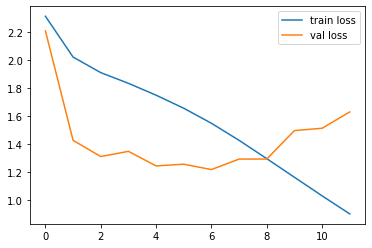

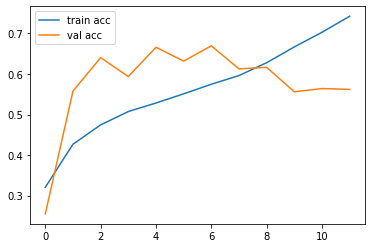

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(mdl_fit.history['loss'], label='train loss')
plt.plot(mdl_fit.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig(txt+'_LossVal_loss')

# plot the accuracy
plt.plot(mdl_fit.history['accuracy'], label='train acc')
plt.plot(mdl_fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig(txt+'_AccVal_acc')

#save model to disk
model.save_weights('model.h5') 